In [37]:
import warnings
warnings.filterwarnings('ignore' )
import numpy as np
import torch as nn

from simu_pp import simu
from model import Model
from solver import initialize, compute_loss, optimizer, training_loop
from utils_plot import plot_global_fig, check_tensor

In [2]:
# model parameters
mu0_true, alpha_true, mu_true, sig_true   = 1, 0.7, 0.4, 0.4
true_params = np.array([mu0_true, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = 0
T = 10_000
L = 100
dt = 1 / L
p_task = 0.6
t = torch.arange(0, 1, dt)

reparam = True

# simulate data
kernel_value, intensity_value, driver_tt, driver, acti_tt, acti = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=False)

In [3]:
# model parameters
baseline = 1
n_drivers = 2
driver1 = [0.7, 0.4, 0.4]  # [alpha, m, sigma]
driver2 = [0.5, 0.6, 0.2]  # [alpha, m, sigma]
params = [baseline]
for this_driver in [driver1, driver2]:
    params.extend(this_driver)
    
params

[1, 0.7, 0.4, 0.4, 0.5, 0.6, 0.2]

In [41]:
example_tensor = nn.tensor([[10, 20, 30, 40],
                            [50, 60, 70, 80],
                            [90, 100, 110, 120]])

ValueError: expected sequence of length 1 at dim 1 (got 4)

In [53]:
params = nn.tensor([[1, np.nan],      # baseline
                    [0.7, 0.5],  # alpha
                    [0.4, 0.6],  # m
                    [0.4, 0.2]]) # sigma



tensor([0.7000, 0.4000, 0.4000])

In [22]:
i=2
id_min = 1 + (i-1)*3
id_max = id_min + 3
print(id_min, id_max)
print(params[id_min:id_max])

4 7
[0.5, 0.6, 0.2]


In [28]:
from kernels import raised_cosine_kernel

def get_driver_i_params(params, i):
    """Assumed there is 3 parameters per driver
    
    Parameters
    params : 1d array-like
    """
    id_min = 1 + (i-1)*3
    id_max = id_min + 3
    return params[id_min:id_max]

kernels = []
for i in range(n_drivers):
    this_kernel_params = get_driver_i_params(params, i+1)
    print(this_kernel_params)
    this_kernel = raised_cosine_kernel(t, this_kernel_params)
    kernels.append(this_kernel)

[0.7, 0.4, 0.4]
[0.5, 0.6, 0.2]


2

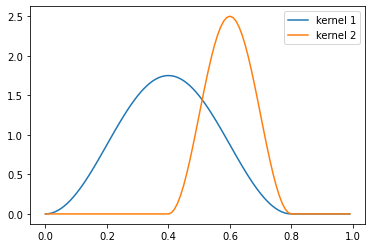

In [33]:
import matplotlib.pyplot as plt

for i in range(n_drivers):
    plt.plot(t, kernels[i], label=f"kernel {i+1}")
    plt.legend()


In [15]:

    

def reparam(params, n_drivers):
    params[(1+n_drivers):(1+2*n_drivers)] -= params[(1+2*n_drivers):(1+3*n_drivers)]
    return params

params = np.array([1, .7, 0.2, 0.4, 0.7, 0.4, 0.3])
print(reparam(params, n_drivers=2))

params = np.array([1, 0.7, 0.4, 0.4])
print(reparam(params, n_drivers=1))

[1.  0.7 0.2 0.  0.4 0.4 0.3]
[1.  0.7 0.  0.4]


In [18]:
params = np.array([1, .7, 0.2, 0.4, 0.7, 0.4, 0.3])
params[[2, 5]] -= params[[3, 6]]
params

array([ 1. ,  0.7, -0.2,  0.4,  0.7,  0.1,  0.3])

In [3]:
# initialize parameters
init_method = 'random'

if init_method == 'random':
    rng = np.random.RandomState(seed=seed)
    p = 0.6  # init parameters are +- p% around true parameters
    init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
    init_params = init_params.clip(1e-5)
elif init_method == 'moment_matching':
    init_params = initialize(driver_tt, acti_tt, T, initializer='smart_start', lower=0, upper=0.8,
               kernel_name='raised_cosine')
    mu0_init, alpha_init, m_init, sigma_init = init_params
    init_params = [mu0_init, alpha_init[0], m_init[0], sigma_init[0]]
    
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

True parameters: [1.  0.7 0.4 0.4]
Initial parameters: [1.0585762  0.88075907 0.44932642 0.42154393]


In [4]:
#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 500
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  

def expe(solver='Adam', step_size=1e-3):
    model_raised = Model(t, check_tensor(init_params), dt, kernel_name, loss_name)

    opt =  optimizer(model_raised.parameters(), step_size, solver)

    res_dict = training_loop(model_raised, opt, driver, acti, max_iter, test)

    # plot final figure
    fig = plot_global_fig(intensity_value,
                          est_intensity=res_dict['est_intensity'],
                          true_kernel=kernel_value,
                          est_kernel=res_dict['est_kernel'],
                          pobj=res_dict['pobj'],
                          test_intensity=res_dict['test_intensity'],
                          pval=res_dict['pval'],
                          loss=loss_name,
                          figtitle="res_"+solver+'.pdf')
    return fig



In [5]:
params = check_tensor(init_params)
mu_0, alpha, mu, sig = params
n_drivers = len(np.atleast_1d(alpha))
n_drivers

1

Fitting model... done (252.0 s.) 
Estimated parameters: [1.02120782 0.68141542 0.3964652  0.3997861 ]


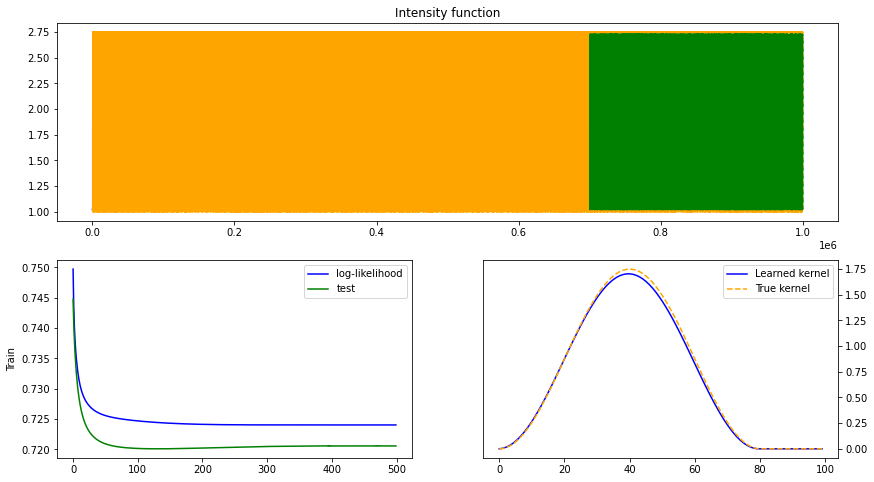

In [6]:

# run gradient descent
#for solver in ['Adam', 'RMSprop', 'GD']:  # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
#    print(f"solver: {solver}")
#    fig = expe(solver, step_size=1e-3)
fig = expe('RMSprop', step_size=1e-3)    



solver: LBFGS
Fitting model... done (223.0 s.) 
Estimated parameters: [1.00954323 1.05623821 0.39754828 0.07193837]


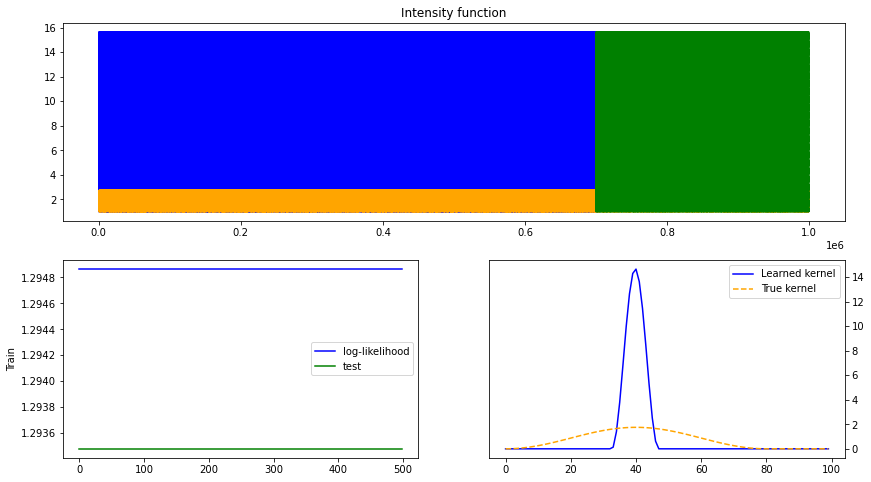

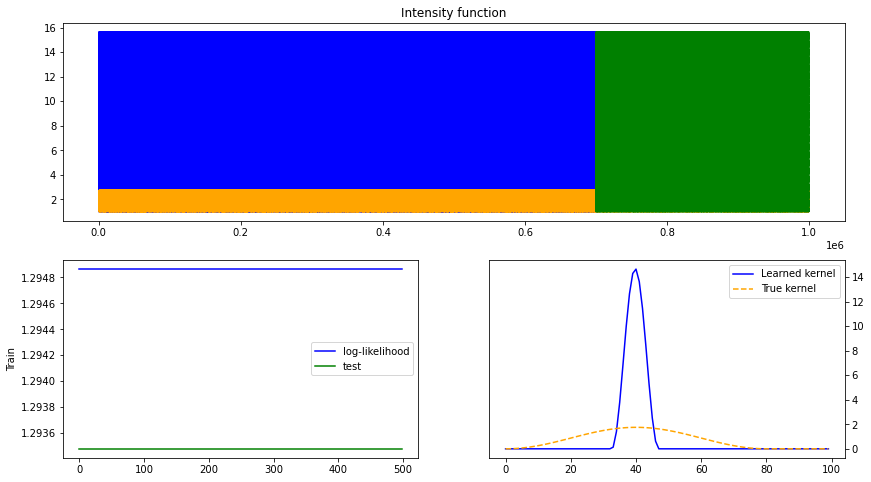

In [5]:
solver = 'LBFGS'
print(f"solver: {solver}")
expe(solver, step_size=1e-3)

In [ ]:
# model parameters
mu_0, alpha_true, mu_true, sig_true   = 0.8, 0.4, 0.7, 0.2
true_params = np.array([mu_0, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = 0

L = 100
dt = 1 / L
p_task = 0.6

# simulate data
true_kernel, true_intensity, driver_tt, acti_tt, in_poi = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=False)



# initialize parameters
rng = np.random.RandomState(seed=seed)
p = 0.6  # init parameters are +- p% around true parameters
init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
init_params = init_params.clip(1e-5)
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 200
step_size = 1e-2
solver = 'Adam' # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'
t = torch.arange(0, 1, dt)

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  

# run gradient descent
expe('Adam', 1e-3)
expe('RMSprop', 1e-3)
expe('GD', 1e-3)



In [ ]:
# model parameters
mu_0, alpha_true, mu_true, sig_true   = 0.8, 0.4, 0.5, 0.5
true_params = np.array([mu_0, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = 0

L = 100
dt = 1 / L
p_task = 0.6

# simulate data
true_kernel, true_intensity, driver_tt, acti_tt, in_poi = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=False)



# initialize parameters
rng = np.random.RandomState(seed=seed)
p = 0.6  # init parameters are +- p% around true parameters
init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
init_params = init_params.clip(1e-5)
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 200
step_size = 1e-2
solver = 'Adam' # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'
t = torch.arange(0, 1, dt)

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  

# run gradient descent
expe('Adam', 1e-3)
expe('RMSprop', 1e-3)
expe('GD', 1e-3)


In [ ]:
# model parameters
mu_0, alpha_true, mu_true, sig_true   = 2, -0.2, 0.4, 0.4
true_params = np.array([mu_0, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = 0
T = 10000
L = 100
dt = 1 / L
p_task = 0.6

# simulate data
true_kernel, true_intensity, driver_tt, acti_tt, in_poi = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=False)



# initialize parameters
rng = np.random.RandomState(seed=seed)
p = 0.6  # init parameters are +- p% around true parameters
init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
init_params = init_params.clip(1e-5)
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 200
step_size = 1e-2
solver = 'Adam' # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'
t = torch.arange(0, 1, dt)

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  


def expe(solverr=solver, step_size=step_size):
    model_raised = Model(t, check_tensor(init_params), dt, kernel_name, loss_name)

    opt =  optimizer(model_raised.parameters(), step_size, solverr)

    res_dict = training_loop(model_raised, opt, driver_tt, acti_tt, max_iter, test)

    # plot final figure
    fig = plot_global_fig(true_intensity, est_intensity=res_dict['est_intensity'],
                              true_kernel=true_kernel, est_kernel=res_dict['est_kernel'],
                              pobj=res_dict['pobj'], test_intensity=res_dict['test_intensity'],
                              pval=res_dict['pval'], loss=loss_name)
    return 0

# run gradient descent

expe('Adam', 1e-3)
expe('RMSprop', 1e-3)
expe('GD', 1e-3)

In [ ]:
# model parameters
mu_0, alpha_true, mu_true, sig_true   = 0.8, 0.4, 0.5, 0.5
true_params = np.array([mu_0, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = 0

L = 100
dt = 1 / L
p_task = 0.6

# simulate data
true_kernel, true_intensity, driver_tt, acti_tt, in_poi = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=False)



# initialize parameters
rng = np.random.RandomState(seed=seed)
p = 2  # init parameters are +- p% around true parameters
init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
init_params = init_params.clip(1e-5)
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 500
step_size = 1e-2
solver = 'Adam' # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'
t = torch.arange(0, 1, dt)

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  

# run gradient descent
expe('Adam', 1e-3)
expe('RMSprop', 1e-3)
expe('GD', 1e-3)

